In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from cataclop.ml import preprocessing
from cataclop.ml import exploration

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

from cataclop.ml.pipeline import factories

In [2]:
program = factories.Program.factory('default', version='1.1')

In [3]:
program.train(dataset_params = {
    #'from': '2013-05-10'
    'from': '2018-01-01',
    'to': '2018-06-30',
    'sub_categories': ['AUTOSTART']
}, model_params = {
    'kfolds': 3,
    'nan_flag': 100000,
    'n_targets': 2
})

loading data a432b7a29a7432c8f067ef8f58164ed4 from cache
preparing model data
training xgb_10
training xgb_30
training xgb_100
training knn_1
training knn_2
training knn_3
training knn_4
training knn_5
training knn_6
training knn_7
training knn_8
training knn_9
training knn_10
training xgb_10
training xgb_30
training xgb_100
training knn_1
training knn_2
training knn_3
training knn_4
training knn_5
training knn_6
training knn_7
training knn_8
training knn_9
training knn_10
training xgb_10
training xgb_30
training xgb_100
training knn_1
training knn_2
training knn_3
training knn_4
training knn_5
training knn_6
training knn_7
training knn_8
training knn_9
training knn_10
preparing stacked model data
training mlp_sigmoid
/Users/pourquoi/.local/share/virtualenvs/cataclop-django-M9amAh3O/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % sel

In [4]:
len(program.model.models[0]['estimators'])
program.model.hash

'288e902a9cd69b8d95b9c3904340fb19'

In [5]:
program.dataset.save()
program.model.save()

In [65]:
#program.lock('2019-01-24')

In [6]:
print('{} races from {} to {}'.format(program.df.race_id.nunique(), program.df.start_at.min(), program.df.start_at.max()))

665 races from 2018-01-01 11:40:00 to 2018-06-29 22:30:00


In [7]:
for model in program.model.models:
    clf = model['estimators'][-1]['pipeline'].steps[-1][1]
    if hasattr(clf, 'classes_'):
        clf = model['estimators'][-1]['pipeline'].steps[-1][1]
        print(clf.classes_)

[1 2]
[1 2]
[1 2]
[1 2]
[1 2]
[1 2]
[1 2]
[1 2]
[1 2]
[1 2]
[1 2]
[1 2]
[1 2]


In [8]:
pd.set_option('precision',32)
    
for model in program.model.models:
    clf = model['estimators'][-1]['pipeline'].steps[-1][1]
    if hasattr(clf, 'feature_importances_'):
        fi = pd.Series(clf.feature_importances_, index=program.model.features+preprocessing.get_dummy_features(model['estimators'][-1]['dummies']))
        print(model['name'])
        print(fi.sort_values(ascending=False)[0:100])
        print("---\n")
    if hasattr(clf, 'coef_'):
        fi = pd.Series(clf.coef_, index=program.model.features+preprocessing.get_dummy_features(model['estimators'][-1]['dummies']))
        print(model['name'])
        print(fi.sort_values(ascending=False)[0:100])
        print("---\n")


for model in program.model.stacked_models:
    clf = model['estimators'][-1]['pipeline'].steps[-1][1]
    if hasattr(clf, 'feature_importances_'):
        fi = pd.Series(clf.feature_importances_, index=program.model.stacked_features+preprocessing.get_dummy_features(model['estimators'][-1]['dummies']))
        print(model['name'])
        print(fi.sort_values(ascending=False)[0:100])
        print("---\n")
    if hasattr(clf, 'coef_'):
        fi = pd.Series(clf.coef_, index=program.model.stacked_features+preprocessing.get_dummy_features(model['estimators'][-1]['dummies']))
        print(model['name'])
        print(fi.sort_values(ascending=False)[0:100])
        print("---\n")
        
pd.set_option('precision',7)



xgb_10
victory_earnings_r              0.185714289546012878417968750000
hist_1_pos                      0.171428576111793518066406250000
declared_player_count           0.142857149243354797363281250000
race_count_r                    0.142857149243354797363281250000
victory_count_r                 0.071428574621677398681640625000
hist_3_pos                      0.071428574621677398681640625000
num                             0.042857144027948379516601562500
odds_8                          0.042857144027948379516601562500
prev_year_earnings              0.028571428731083869934082031250
hist_2_pos                      0.028571428731083869934082031250
odds_2                          0.014285714365541934967041015625
race_count                      0.014285714365541934967041015625
victory_earnings                0.014285714365541934967041015625
odds_6                          0.014285714365541934967041015625
odds_7                          0.014285714365541934967041015625
placed_2_count_r  

In [9]:
df = program.df

for model in program.model.models:
    print(model['name'], df['pred_{}_1'.format(model['name'])].mean())

xgb_10 0.3291266946768991
xgb_30 0.24654386417957388
xgb_100 0.23429810608003926
knn_1 0.25406743692525346
knn_2 0.253065314784249
knn_3 0.2508056276035526
knn_4 0.24746522046687103
knn_5 0.24847913228012267
knn_6 0.24754381828185174
knn_7 0.24736416613332426
knn_8 0.24641888705493986
knn_9 0.24586706489559595
knn_10 0.24439990568262202


In [10]:
#exploration.random_race(df, cols=['position', 'declared_player_count', 'sub_category', 'num', 'final_odds', 'final_odds_ref', 'pred_stacked'] + ['pred_stacked_{}'.format(pos+1) for pos in range(1,8)] + ['pred_xgb_100_1', 'pred_rf_100_1', 'pred_knn_5_1', 'pred_mlp_100_1', 'pred_ridge_1_1']).sort_values(by='pred_stacked_8', ascending=False)

exploration.random_race(df, cols=['position', 'declared_player_count', 'sub_category', 'num', 'final_odds', 'final_odds_ref', 'target_pos', 'target_returns'] + ['pred_{}_1'.format(model['name']) for model in program.model.models] + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models]).sort_values(by='position', ascending=True)



position  declared_player_count sub_category  num  final_odds  \
race_id                                                                       
17852   5485       1.0                     14    AUTOSTART    6         2.4   
        5490       2.0                     14    AUTOSTART   11        16.6   
        5481       3.0                     14    AUTOSTART    2        23.9   
        5492       4.0                     14    AUTOSTART   13        19.8   
        5487       5.0                     14    AUTOSTART    8        55.8   
        5480       6.0                     14    AUTOSTART    1        11.6   
        5482       7.0                     14    AUTOSTART    3        28.7   
        5491       8.0                     14    AUTOSTART   12        13.3   
        5493       9.0                     14    AUTOSTART   14        26.0   
        5489      10.0                     14    AUTOSTART   10       118.1   
        5483       NaN                     14    AUTOSTART    4         4.3   
        5484       NaN                     14    AUTOSTART    5        83.7   
        5486       NaN                     14    AUTOSTART    7        20.9   
        5488       NaN                     14    AUTOSTART    9        14.1   

              final_odds_ref  target_pos  target_returns  pred_xgb_10_1  \
race_id                                                                   
17852   5485             3.4           1             1.9      0.4253009   
        5490            10.7           1             0.0      0.2991909   
        5481            82.7           1             0.0      0.3150892   
        5492             8.9           2             0.0      0.2543042   
        5487            23.2           2             0.0      0.3168467   
        5480             5.5           2             0.0      0.3098837   
        5482            46.5           2             0.0      0.3150892   
        5491            21.2           2             0.0      0.2634473   
        5493             9.6           2             0.0      0.2360558   
        5489            82.7           2             0.0      0.2694539   
        5483             6.2           2             0.0      0.3792722   
        5484           124.1           2             0.0      0.3640579   
        5486            19.6           2             0.0      0.3112729   
        5488            22.5           2             0.0      0.3277308   

              pred_xgb_30_1  pred_xgb_100_1  pred_knn_1_1  pred_knn_2_1  \
race_id                                                                   
17852   5485      0.4952221       0.6478021           0.0           0.0   
        5490      0.2149109       0.2953249           0.0           0.0   
        5481      0.1703157       0.1652213           0.0           0.5   
        5492      0.1353353       0.0796782           0.0           0.0   
        5487      0.1813658       0.1242432           0.0           0.5   
        5480      0.2541288       0.3200740           1.0           1.0   
        5482      0.1667038       0.1023288           0.0           0.0   
        5491      0.1608041       0.1570271           0.0           0.0   
        5493      0.0894273       0.0477160           0.0           0.0   
        5489      0.1422637       0.1006176           0.0           0.0   
        5483      0.3640367       0.5044369           0.0           0.5   
        5484      0.4098347       0.5045134           0.0           0.0   
        5486      0.1724953       0.1145166           1.0           0.5   
        5488      0.2220418       0.2777380           0.0           0.5   

              pred_knn_3_1  pred_knn_4_1  pred_knn_5_1  pred_knn_6_1  \
race_id                                                                
17852   5485     0.0000000          0.00           0.0     0.0000000   
        5490     0.0000000          0.00           0.0     0.0000000   
        5481     0.3333333          0.25           0.4     

In [11]:
#df['pred_sum'] = df[['pred_{}_1'.format(model['name']) for model in program.model.models ]].sum(axis=1)
#df['pred_sum'] = df[['pred_knn_{}_1'.format(n) for n in [5,10,20,30]]].sum(axis=1)
df['pred_sum'] = df[['pred_{}_1'.format(model['name']) for model in program.model.models ]].sum(axis=1)

'''
for model in program.model.models:
    df['pred_{}_1_3'.format(model['name'])] = df[ ['pred_{}_{}'.format(model['name'], i) for i in range(1,4) ] ].sum(axis=1)
    df['pred_{}_2_4'.format(model['name'])] = df[ ['pred_{}_{}'.format(model['name'], i) for i in range(2,5) ] ].sum(axis=1)
'''


"\nfor model in program.model.models:\n    df['pred_{}_1_3'.format(model['name'])] = df[ ['pred_{}_{}'.format(model['name'], i) for i in range(1,4) ] ].sum(axis=1)\n    df['pred_{}_2_4'.format(model['name'])] = df[ ['pred_{}_{}'.format(model['name'], i) for i in range(2,5) ] ].sum(axis=1)\n"

In [12]:
df['pred_rnd'] = np.random.rand(df.shape[0])

'''
for model in program.model.models:
    df['pred_minus_ref_{}'.format(model['name'])] = (-df['pred_{}_1'.format(model['name'])]-df['final_odds_ref']).pow(2).pow(0.5)
    
for model in program.model.stacked_models:
    df['pred_minus_ref_stacked_{}'.format(model['name'])] = (-df['pred_stacked_{}_1'.format(model['name'])]-df['final_odds_ref']).pow(2).pow(0.5)
'''

"\nfor model in program.model.models:\n    df['pred_minus_ref_{}'.format(model['name'])] = (-df['pred_{}_1'.format(model['name'])]-df['final_odds_ref']).pow(2).pow(0.5)\n    \nfor model in program.model.stacked_models:\n    df['pred_minus_ref_stacked_{}'.format(model['name'])] = (-df['pred_stacked_{}_1'.format(model['name'])]-df['final_odds_ref']).pow(2).pow(0.5)\n"

In [13]:
#program.bet(N=1, max_odds=20, targets=['pred_rnd', 'final_odds_ref', 'pred_sum'] + ['pred_{}_1'.format(model['name']) for model in program.model.models])
#bets = program.bets
#bets['profit'].mean()

In [14]:
program.model.features

['declared_player_count',
 'handicap_distance',
 'handicap_distance_amax',
 'handicap_distance_amin',
 'handicap_distance_mean',
 'handicap_distance_r',
 'handicap_distance_std',
 'handicap_weight',
 'handicap_weight_amax',
 'handicap_weight_amin',
 'handicap_weight_mean',
 'handicap_weight_r',
 'handicap_weight_std',
 'hist_1_pos',
 'hist_2_pos',
 'hist_3_pos',
 'hist_4_pos',
 'hist_5_pos',
 'hist_6_pos',
 'num',
 'odds_0',
 'odds_1',
 'odds_2',
 'odds_3',
 'odds_4',
 'odds_5',
 'odds_6',
 'odds_7',
 'odds_8',
 'odds_9',
 'placed_2_count',
 'placed_2_count_amax',
 'placed_2_count_amin',
 'placed_2_count_mean',
 'placed_2_count_r',
 'placed_2_count_std',
 'placed_3_count',
 'placed_3_count_amax',
 'placed_3_count_amin',
 'placed_3_count_mean',
 'placed_3_count_r',
 'placed_3_count_std',
 'placed_earnings',
 'placed_earnings_amax',
 'placed_earnings_amin',
 'placed_earnings_mean',
 'placed_earnings_r',
 'placed_earnings_std',
 'prev_year_earnings',
 'prev_year_earnings_amax',
 'prev_yea

In [15]:
def bet(df, features, categorical_features, targets, N=1, max_odds=20, break_on_bet=True, break_on_odds=False):

    races = df.sort_values('start_at').groupby('race_id')

    bets = []

    for (id, race) in races:

        candidate_bets = []

        nums = []

        for target in targets:

            r = race.sort_values(by=target, ascending=False)

            if len(r) <= N:
                break
                
            NN = N

            for n in range(NN):

                player = r.iloc[n]

                odds = player['final_odds_ref']

                if max_odds is not None and odds > max_odds:
                    if break_on_odds:
                        break
                    else:
                        continue

                nth = (r['final_odds_ref']<odds).sum()+1
                
                #bet = np.clip(np.abs(player[target])/100.0, 0, 10)
                
                #bet = np.round(1+bet) * 1.5
                
                #if bet <= 0:
                #    break
                
                if n+1 < len(r) and r.iloc[n+1][target] == player[target]:
                    NN = NN+1
                    
                bet = 1

                profit = player['winner_dividend']/100.0 * bet - bet
                profit_placed = player['placed_dividend']/100.0 * bet - bet

                row = [id, player['start_at'], player['num'], player['position'], n, odds, player['final_odds'], target, player[target], r[target].std(), bet, profit, profit_placed]

                for nn in range(1,4):
                    if n+nn < len(r):
                        row.append(r.iloc[n+nn][target])
                    else:
                        row.append(np.nan)

                for f in features:
                    row.append(player[f])
                for f in categorical_features:
                    row.append(player[f])

                candidate_bets.append( row )

                nums.append(player['num'])

                if break_on_bet:
                    break

        #if len(candidate_bets) == 1:
        #    bets += candidate_bets
        bets += candidate_bets

    cols = ['id', 'date', 'num', 'pos', 'nb', 'odds_ref', 'odds_final', 'target', 'pred', 'pred_std', 'bet', 'profit', 'profit_placed']

    for nn in range(1,4):
        cols.append('next_pred_{}'.format(nn))

    cols = cols + features + categorical_features

    bets = pd.DataFrame(bets, columns=cols)
    bets['date'] = pd.to_datetime(bets['date'])

    bets = bets.set_index(bets['date'])
    bets = bets.sort_index()

    bets['bets'] = bets['bet'].cumsum()
    bets['stash'] = bets['profit'].cumsum()

    return bets



In [16]:
def bet2(df):

    races = df.sort_values('start_at').groupby('race_id')
    
    bet = 0
    profit = 0
    
  
    strats = [
            [1, 1, 1],
            [0, 1, 1, 1],
            [0, 0, 1, 1, 1],
            [0, 0, 0, 1, 1, 1],
            [0, 0, 0, 0, 1, 1, 1],
        ]


    
    for (id, race) in races:

        r = race.sort_values(by='final_odds_ref', ascending=True)
        
        '''
        if r.iloc[0]['final_odds_ref'] > 20:
            continue
            
        if r.iloc[0]['final_odds_ref'] < 3:
            continue
        
        bet += 1
        profit += r.iloc[0]['winner_dividend']/100.0 * 1 - 1
        
        continue
        '''
        

        si = int(list(r['pred_xgb_100'].value_counts().index)[0])
        
        if si == 0:
            continue
            
        strat = strats[si-1]
        
        
        for n in range(len(strat)):
            
            if r.iloc[n]['final_odds_ref'] > 20 or r.iloc[n]['final_odds_ref'] < 3:
                continue
            
            bet += strat[n]
            profit += r.iloc[n]['winner_dividend']/100.0 * strat[n] - strat[n]

        
        '''
        for strat in strats:
            for n in range(len(strat)):
                if len(r) <= n:
                    break
                b = strat[n] * r.iloc[0]['pred_xgb_100_{}'.format(n+1)]
                bet += b
                profit += r.iloc[n]['winner_dividend']/100.0 * b - b
        '''
    
    return (bet, profit)
        

        

In [17]:

bets = bet(df, program.model.features, program.model.categorical_features, 
    N=6, max_odds=None, break_on_bet=False, break_on_odds=False, 
    targets=['pred_rnd', 'final_odds_ref', 'pred_sum'] + ['pred_{}_{}'.format(model['name'], i+1) for i in range(program.model.params['n_targets']) for model in program.model.models] + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models] 
   )

'''
['pred_{}_{}'.format(model['name'], i) for model in program.model.models for i in ['1_3', '2_4'] ]
bets = bet(df, program.model.features, program.model.categorical_features, 
    N=3, max_odds=30, break_on_bet=False, break_on_odds=False, 
    targets=['pred_rnd', 'final_odds_ref', 'pred_sum'] + ['pred_{}_1'.format(model['name']) for model in program.model.models] + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models]
   )
'''
    

"\n['pred_{}_{}'.format(model['name'], i) for model in program.model.models for i in ['1_3', '2_4'] ]\nbets = bet(df, program.model.features, program.model.categorical_features, \n    N=3, max_odds=30, break_on_bet=False, break_on_odds=False, \n    targets=['pred_rnd', 'final_odds_ref', 'pred_sum'] + ['pred_{}_1'.format(model['name']) for model in program.model.models] + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models]\n   )\n"

In [18]:
bets['profit'].describe()

count    122388.0000000
mean         -0.3102061
std           4.6063360
min          -1.0000000
25%          -1.0000000
50%          -1.0000000
75%          -1.0000000
max         181.3000000
Name: profit, dtype: float64

In [19]:
df[['pred_{}_1'.format(model['name']) for model in program.model.models]].describe()

,pred_xgb_10_1,pred_xgb_30_1,pred_xgb_100_1,pred_knn_1_1,pred_knn_2_1,pred_knn_3_1,pred_knn_4_1,pred_knn_5_1,pred_knn_6_1,pred_knn_7_1,pred_knn_8_1,pred_knn_9_1,pred_knn_10_1
count,8482.0000000,8482.0000000,8482.0000000,8482.0000000,8482.0000000,8482.0000000,8482.0000000,8482.0000000,8482.0000000,8482.0000000,8482.0000000,8482.0000000,8482.0000000
mean,0.3291267,0.2465439,0.2342981,0.2540674,0.2530653,0.2508056,0.2474652,0.2484791,0.2475438,0.2473642,0.2464189,0.2458671,0.2443999
std,0.0525993,0.0926472,0.1318475,0.4353614,0.3017157,0.2454388,0.2098058,0.1869411,0.1678188,0.1550752,0.1445291,0.1372193,0.1308453
min,0.2337364,0.0752235,0.0187486,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
25%,0.2924741,0.1787383,0.1361859,0.0000000,0.0000000,0.0000000,0.0000000,0.2000000,0.1666667,0.1428571,0.1250000,0.1111111,0.2000000
50%,0.3240345,0.2292404,0.2051313,0.0000000,0.0000000,0.3333333,0.2500000,0.2000000,0.1666667,0.2857143,0.2500000,0.2222222,0.2000000
75%,0.3567740,0.2975813,0.3052485,1.0000000,0.5000000,0.3333333,0.5000000,0.4000000,0.3333333,0.2857143,0.3750000,0.3333333,0.3000000
max,0.5593359,0.6939322,0.8761249,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,0.8888889,0.8000000


In [20]:
bets = bets.set_index(bets['date'])
bets = bets.sort_index()

In [21]:
def graph_bb(bb, f):
    results = []

    for s in bb[f].value_counts().index:
        results = []
        x = bb[ (bb[f] == s) & (bb['pred_std'] != 0) & (bb['pred'] != 0) ].copy()
        if len(x) == 0:
            continue
        #print("---\n{}\t{:+.2f}\t{:+.2f}\t{:+.2f}\n---".format(s, x['profit'].sum(), x['bet'].sum(), len(x)))

        fig, axs = plt.subplots(1,1)

        for t in x['target'].value_counts().index:
            bbb = x[(x['target'] == t)].copy()
            #bbb = bbb[ (bbb['pred']>bbb['pred'].quantile(0.85)) ].copy()


            results.append({
                'idx_1': s,
                'idx_2': t,
                'profit': bbb.profit.sum(),
                'profit_place': bbb.profit_placed.sum(),
                'bet': bbb.bet.sum(),
                'bets': bbb.bet.count(),
                'avg': bbb.profit.sum() / bbb.bet.sum()
            })

            '''
            bbb['stash'] = bbb['profit'].cumsum()
            bbb['cbet'] = bbb['bet'].cumsum()

            fig, axs = plt.subplots(1,1)
            bbb['stash'].plot(figsize=(6, 2))
            bbb['cbet'].plot(figsize=(6, 2))
            plt.show()
            '''

            #print("{:10s}: \t {:+.2f} \t {:+.0f} \t {:+.2f}".format(t, bbb.profit.sum(), bbb.profit.count(), bbb.profit.mean()) )

            bbb['stash'] = bbb['profit'].cumsum()
            bbb['cbet'] = bbb['bet'].cumsum()

            bbb['stash'].plot(figsize=(10, 2))
            bbb['cbet'].plot(figsize=(10, 2))

        results = pd.DataFrame(results)
        results = results.set_index(['idx_1', 'idx_2'])
        print(results.sort_values(by='avg', ascending=False))


        plt.show()    

    
    

In [22]:
countries = list(bets['country'].value_counts()[0:10].index)
sub_categories = list(bets['sub_category'].value_counts()[0:10].index)

%store countries
%store sub_categories

Stored 'countries' (list)
Stored 'sub_categories' (list)


In [23]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args

target = 'pred_xgb_100_1'

c_min = bets[(bets['target'] == target)]['pred'].min()
c_mean = bets[(bets['target'] == target)]['pred'].mean()
c_max = bets[(bets['target'] == target)]['pred'].max()

space = [
          Real(1, 10, name='min_odds'),
          Real(10, 60, name='max_odds'),
          Real(c_min, c_mean, name='min_pred'),
          Real(c_mean, c_max, name='max_pred'),
          Integer(5, 25, name='max_players')] + [
          Integer(0,1, name='country_{}'.format(country)) for country in countries] + [
          Integer(0,1, name='sub_category_{}'.format(sub_category)) for sub_category in sub_categories] + [
          Integer(0,1, name='nb_{}'.format(n)) for n in range(0,6)]
         
def x_to_params(x):
    params = {}
    
    params['min_odds'] = x[0]
    params['max_odds'] = x[1]
    params['max_pred'] = x[3]
    params['min_pred'] = x[2]
    params['max_players'] = x[4]
    
    for i, country in enumerate(countries):
        params['country_{}'.format(country)] = x[5+i]
        
    for i, sc in enumerate(sub_categories):
        params['sub_category_{}'.format(sc)] = x[5+len(countries)+i]
        
    for n in range(0,6):
        params['nb_{}'.format(n)] = x[5+len(countries)+len(sub_categories)+n]

    return params

@use_named_args(space)
def f(**params):
    return ff(params)
    
def ff(params, train=True):
    
    print(params)
    
    b = bets[ (bets['pred'] != 0) & (bets['target']==target) & (bets['pred_std'] != 0)]
    
    b = b[ (b['odds_ref'] > params['min_odds']) & (b['odds_ref'] < params['max_odds']) & (b['declared_player_count'] > 1) & (b['declared_player_count'] <= params['max_players']) ]
    
    b = b[(b['pred'] > params['min_pred']) & (b['pred'] < params['max_pred'])]
    
    for country in countries:
        if params['country_{}'.format(country)] == 0:
            b = b[ b['country'] != country ]
            
    for sub_category in sub_categories:
        if params['sub_category_{}'.format(sub_category)] == 0:
            b = b[ b['sub_category'] != sub_category ]
            
    for n in range(0,6):
        if params['nb_{}'.format(n)] == 0:
            b = b[ b['nb'] != n]
    
    p = b.profit.sum()
    pp = len(b[b['profit'] > 0])
    bet = b.bet.sum()
    
    print("{:+.2f} {:+.2f}\n".format(p, bet))
        
    if bet == 0:
        return 0
    
    if not train:
        return b
    
    return - (p)
    
    

In [24]:
c_mean, c_min, c_max

(0.3357225040534347, 0.12075585126876831, 0.876124918460846)

In [25]:
from skopt import dummy_minimize, gp_minimize, gbrt_minimize

res = dummy_minimize(f, space, n_calls=500)

{'min_odds': 5.405652998556833, 'max_odds': 54.26864370593611, 'min_pred': 0.16873018503138765, 'max_pred': 0.7482215835527335, 'max_players': 19, 'country_FRA': 0, 'country_ESP': 0, 'country_NLD': 1, 'country_AUT': 1, 'country_BEL': 1, 'country_CHE': 0, 'country_AUS': 1, 'country_IRL': 0, 'country_NOR': 0, 'country_SWE': 1, 'sub_category_AUTOSTART': 0, 'nb_0': 0, 'nb_1': 1, 'nb_2': 0, 'nb_3': 0, 'nb_4': 1, 'nb_5': 0}
+0.00 +0.00

{'min_odds': 5.346609004392062, 'max_odds': 45.33304351409845, 'min_pred': 0.1856460809789182, 'max_pred': 0.7704460784757394, 'max_players': 17, 'country_FRA': 1, 'country_ESP': 1, 'country_NLD': 0, 'country_AUT': 1, 'country_BEL': 1, 'country_CHE': 1, 'country_AUS': 0, 'country_IRL': 1, 'country_NOR': 1, 'country_SWE': 0, 'sub_category_AUTOSTART': 0, 'nb_0': 1, 'nb_1': 0, 'nb_2': 1, 'nb_3': 0, 'nb_4': 1, 'nb_5': 1}
+0.00 +0.00

{'min_odds': 9.799282552811762, 'max_odds': 13.956498018082812, 'min_pred': 0.22951307326460718, 'max_pred': 0.7702480595616978, 'm

+0.00 +0.00

{'min_odds': 8.866772878291712, 'max_odds': 30.705408341081245, 'min_pred': 0.3304470412611696, 'max_pred': 0.5590351137422583, 'max_players': 19, 'country_FRA': 0, 'country_ESP': 0, 'country_NLD': 1, 'country_AUT': 0, 'country_BEL': 0, 'country_CHE': 1, 'country_AUS': 0, 'country_IRL': 1, 'country_NOR': 1, 'country_SWE': 1, 'sub_category_AUTOSTART': 1, 'nb_0': 0, 'nb_1': 0, 'nb_2': 1, 'nb_3': 1, 'nb_4': 0, 'nb_5': 1}
-31.60 +75.00

{'min_odds': 9.776802288546744, 'max_odds': 31.383712701104493, 'min_pred': 0.3144217821167188, 'max_pred': 0.7240195825799495, 'max_players': 14, 'country_FRA': 0, 'country_ESP': 1, 'country_NLD': 0, 'country_AUT': 0, 'country_BEL': 0, 'country_CHE': 1, 'country_AUS': 1, 'country_IRL': 0, 'country_NOR': 0, 'country_SWE': 1, 'sub_category_AUTOSTART': 0, 'nb_0': 1, 'nb_1': 1, 'nb_2': 0, 'nb_3': 1, 'nb_4': 0, 'nb_5': 0}
+0.00 +0.00

{'min_odds': 6.925551247184335, 'max_odds': 32.72558271935648, 'min_pred': 0.28428643251162483, 'max_pred': 0.75105

-10.90 +112.00

{'min_odds': 2.332243958986259, 'max_odds': 17.296800963967737, 'min_pred': 0.20873436141327778, 'max_pred': 0.3888861762794934, 'max_players': 21, 'country_FRA': 0, 'country_ESP': 0, 'country_NLD': 0, 'country_AUT': 1, 'country_BEL': 0, 'country_CHE': 1, 'country_AUS': 1, 'country_IRL': 0, 'country_NOR': 0, 'country_SWE': 1, 'sub_category_AUTOSTART': 1, 'nb_0': 0, 'nb_1': 1, 'nb_2': 0, 'nb_3': 1, 'nb_4': 0, 'nb_5': 1}
-15.80 +109.00

{'min_odds': 7.576031786665699, 'max_odds': 14.831268469289196, 'min_pred': 0.27000486782944844, 'max_pred': 0.4005577174122963, 'max_players': 22, 'country_FRA': 1, 'country_ESP': 0, 'country_NLD': 0, 'country_AUT': 1, 'country_BEL': 1, 'country_CHE': 0, 'country_AUS': 0, 'country_IRL': 1, 'country_NOR': 1, 'country_SWE': 0, 'sub_category_AUTOSTART': 1, 'nb_0': 1, 'nb_1': 1, 'nb_2': 0, 'nb_3': 1, 'nb_4': 0, 'nb_5': 1}
-53.60 +207.00

{'min_odds': 3.5885908056433875, 'max_odds': 51.86809032226979, 'min_pred': 0.1755898349824342, 'max_pred'

-205.70 +570.00

{'min_odds': 9.557945314901271, 'max_odds': 10.392576188644506, 'min_pred': 0.3185558475308172, 'max_pred': 0.8457044208452125, 'max_players': 18, 'country_FRA': 0, 'country_ESP': 1, 'country_NLD': 1, 'country_AUT': 1, 'country_BEL': 1, 'country_CHE': 1, 'country_AUS': 1, 'country_IRL': 0, 'country_NOR': 1, 'country_SWE': 1, 'sub_category_AUTOSTART': 0, 'nb_0': 0, 'nb_1': 0, 'nb_2': 1, 'nb_3': 0, 'nb_4': 0, 'nb_5': 0}
+0.00 +0.00

{'min_odds': 8.470532475800422, 'max_odds': 19.985377265803375, 'min_pred': 0.12682181390853514, 'max_pred': 0.6712633816719817, 'max_players': 17, 'country_FRA': 0, 'country_ESP': 1, 'country_NLD': 0, 'country_AUT': 0, 'country_BEL': 0, 'country_CHE': 0, 'country_AUS': 1, 'country_IRL': 0, 'country_NOR': 0, 'country_SWE': 1, 'sub_category_AUTOSTART': 0, 'nb_0': 0, 'nb_1': 1, 'nb_2': 1, 'nb_3': 1, 'nb_4': 0, 'nb_5': 1}
+0.00 +0.00

{'min_odds': 6.5733170198997, 'max_odds': 28.255237867256916, 'min_pred': 0.125142970894536, 'max_pred': 0.85040

+14.30 +172.00

{'min_odds': 2.8076039101577805, 'max_odds': 47.84414712009624, 'min_pred': 0.22091435710082918, 'max_pred': 0.46440575381428284, 'max_players': 17, 'country_FRA': 0, 'country_ESP': 0, 'country_NLD': 0, 'country_AUT': 1, 'country_BEL': 0, 'country_CHE': 1, 'country_AUS': 1, 'country_IRL': 0, 'country_NOR': 0, 'country_SWE': 0, 'sub_category_AUTOSTART': 1, 'nb_0': 0, 'nb_1': 0, 'nb_2': 0, 'nb_3': 0, 'nb_4': 0, 'nb_5': 0}
+0.00 +0.00

{'min_odds': 7.899299101919864, 'max_odds': 20.343182481148894, 'min_pred': 0.17385483721936426, 'max_pred': 0.8686206910761951, 'max_players': 6, 'country_FRA': 0, 'country_ESP': 0, 'country_NLD': 0, 'country_AUT': 0, 'country_BEL': 1, 'country_CHE': 0, 'country_AUS': 1, 'country_IRL': 1, 'country_NOR': 1, 'country_SWE': 0, 'sub_category_AUTOSTART': 1, 'nb_0': 1, 'nb_1': 0, 'nb_2': 0, 'nb_3': 0, 'nb_4': 0, 'nb_5': 1}
+0.00 +0.00

{'min_odds': 4.776064807819853, 'max_odds': 28.674966655472637, 'min_pred': 0.2702941437975887, 'max_pred': 0.75

+0.00 +0.00

{'min_odds': 2.912176667885606, 'max_odds': 51.804441171042, 'min_pred': 0.17644698128170838, 'max_pred': 0.8148466448997156, 'max_players': 8, 'country_FRA': 1, 'country_ESP': 1, 'country_NLD': 1, 'country_AUT': 0, 'country_BEL': 1, 'country_CHE': 1, 'country_AUS': 0, 'country_IRL': 1, 'country_NOR': 1, 'country_SWE': 0, 'sub_category_AUTOSTART': 0, 'nb_0': 0, 'nb_1': 0, 'nb_2': 0, 'nb_3': 0, 'nb_4': 0, 'nb_5': 1}
+0.00 +0.00

{'min_odds': 1.8588483375315383, 'max_odds': 19.656111190311563, 'min_pred': 0.26800004645456166, 'max_pred': 0.3711907302722414, 'max_players': 21, 'country_FRA': 1, 'country_ESP': 0, 'country_NLD': 1, 'country_AUT': 0, 'country_BEL': 0, 'country_CHE': 1, 'country_AUS': 1, 'country_IRL': 0, 'country_NOR': 1, 'country_SWE': 1, 'sub_category_AUTOSTART': 1, 'nb_0': 0, 'nb_1': 1, 'nb_2': 1, 'nb_3': 1, 'nb_4': 1, 'nb_5': 0}
-195.70 +627.00

{'min_odds': 2.592861363715942, 'max_odds': 53.359670578991086, 'min_pred': 0.12708139995862178, 'max_pred': 0.384

-386.00 +873.00

{'min_odds': 9.123703514413336, 'max_odds': 14.713715604448694, 'min_pred': 0.3019347385298764, 'max_pred': 0.7243417606008876, 'max_players': 18, 'country_FRA': 0, 'country_ESP': 0, 'country_NLD': 0, 'country_AUT': 0, 'country_BEL': 0, 'country_CHE': 0, 'country_AUS': 1, 'country_IRL': 0, 'country_NOR': 1, 'country_SWE': 1, 'sub_category_AUTOSTART': 1, 'nb_0': 0, 'nb_1': 0, 'nb_2': 1, 'nb_3': 0, 'nb_4': 0, 'nb_5': 0}
-5.00 +5.00

{'min_odds': 8.885921161247484, 'max_odds': 58.53262768696813, 'min_pred': 0.1721603198033818, 'max_pred': 0.6028500312102646, 'max_players': 12, 'country_FRA': 1, 'country_ESP': 1, 'country_NLD': 1, 'country_AUT': 0, 'country_BEL': 0, 'country_CHE': 1, 'country_AUS': 1, 'country_IRL': 1, 'country_NOR': 1, 'country_SWE': 1, 'sub_category_AUTOSTART': 0, 'nb_0': 0, 'nb_1': 1, 'nb_2': 0, 'nb_3': 0, 'nb_4': 0, 'nb_5': 1}
+0.00 +0.00

{'min_odds': 9.184320210696509, 'max_odds': 22.454255891059592, 'min_pred': 0.25220326692884043, 'max_pred': 0.654

+0.00 +0.00

{'min_odds': 6.466252296156172, 'max_odds': 36.495210901562864, 'min_pred': 0.22366991057526725, 'max_pred': 0.8690154176998266, 'max_players': 14, 'country_FRA': 0, 'country_ESP': 0, 'country_NLD': 1, 'country_AUT': 1, 'country_BEL': 0, 'country_CHE': 0, 'country_AUS': 1, 'country_IRL': 1, 'country_NOR': 0, 'country_SWE': 1, 'sub_category_AUTOSTART': 1, 'nb_0': 1, 'nb_1': 0, 'nb_2': 0, 'nb_3': 1, 'nb_4': 0, 'nb_5': 0}
-31.50 +139.00

{'min_odds': 3.646112947509752, 'max_odds': 27.98067476627082, 'min_pred': 0.31928104890667386, 'max_pred': 0.6605720665913851, 'max_players': 10, 'country_FRA': 1, 'country_ESP': 1, 'country_NLD': 0, 'country_AUT': 1, 'country_BEL': 0, 'country_CHE': 0, 'country_AUS': 0, 'country_IRL': 0, 'country_NOR': 1, 'country_SWE': 0, 'sub_category_AUTOSTART': 0, 'nb_0': 1, 'nb_1': 0, 'nb_2': 1, 'nb_3': 1, 'nb_4': 1, 'nb_5': 1}
+0.00 +0.00

{'min_odds': 8.471292846970256, 'max_odds': 17.48822298523027, 'min_pred': 0.13171193771536144, 'max_pred': 0.844

{'min_odds': 1.7631246668607363, 'max_odds': 38.341973170437655, 'min_pred': 0.20992495370810582, 'max_pred': 0.42078129689653765, 'max_players': 13, 'country_FRA': 0, 'country_ESP': 0, 'country_NLD': 1, 'country_AUT': 0, 'country_BEL': 1, 'country_CHE': 1, 'country_AUS': 1, 'country_IRL': 1, 'country_NOR': 0, 'country_SWE': 0, 'sub_category_AUTOSTART': 1, 'nb_0': 1, 'nb_1': 0, 'nb_2': 0, 'nb_3': 0, 'nb_4': 0, 'nb_5': 0}
-14.60 +19.00

{'min_odds': 3.5703262187603353, 'max_odds': 14.60215559220653, 'min_pred': 0.15667498448360676, 'max_pred': 0.35396353234775757, 'max_players': 10, 'country_FRA': 1, 'country_ESP': 1, 'country_NLD': 0, 'country_AUT': 0, 'country_BEL': 1, 'country_CHE': 1, 'country_AUS': 0, 'country_IRL': 0, 'country_NOR': 0, 'country_SWE': 0, 'sub_category_AUTOSTART': 1, 'nb_0': 1, 'nb_1': 1, 'nb_2': 0, 'nb_3': 0, 'nb_4': 0, 'nb_5': 1}
-10.10 +29.00

{'min_odds': 5.953717790450745, 'max_odds': 12.41333235233226, 'min_pred': 0.1720030845798653, 'max_pred': 0.460175076139

-64.80 +174.00

{'min_odds': 4.158291211686704, 'max_odds': 20.585241597839754, 'min_pred': 0.12166356337820654, 'max_pred': 0.40456234281438014, 'max_players': 15, 'country_FRA': 0, 'country_ESP': 0, 'country_NLD': 0, 'country_AUT': 1, 'country_BEL': 1, 'country_CHE': 1, 'country_AUS': 0, 'country_IRL': 1, 'country_NOR': 0, 'country_SWE': 0, 'sub_category_AUTOSTART': 0, 'nb_0': 0, 'nb_1': 1, 'nb_2': 1, 'nb_3': 0, 'nb_4': 1, 'nb_5': 1}
+0.00 +0.00

{'min_odds': 2.086288001612126, 'max_odds': 23.929433737962455, 'min_pred': 0.12143904328552044, 'max_pred': 0.7693580217556584, 'max_players': 14, 'country_FRA': 1, 'country_ESP': 1, 'country_NLD': 0, 'country_AUT': 0, 'country_BEL': 0, 'country_CHE': 1, 'country_AUS': 1, 'country_IRL': 0, 'country_NOR': 0, 'country_SWE': 0, 'sub_category_AUTOSTART': 0, 'nb_0': 0, 'nb_1': 1, 'nb_2': 0, 'nb_3': 1, 'nb_4': 1, 'nb_5': 1}
+0.00 +0.00

{'min_odds': 3.25540026323481, 'max_odds': 50.397211275365805, 'min_pred': 0.29290800860203603, 'max_pred': 0.6

{'min_odds': 3.6987329253920063, 'max_odds': 29.30613255221287, 'min_pred': 0.16178635245272377, 'max_pred': 0.447679420202143, 'max_players': 17, 'country_FRA': 0, 'country_ESP': 1, 'country_NLD': 0, 'country_AUT': 1, 'country_BEL': 0, 'country_CHE': 0, 'country_AUS': 1, 'country_IRL': 0, 'country_NOR': 1, 'country_SWE': 0, 'sub_category_AUTOSTART': 0, 'nb_0': 1, 'nb_1': 1, 'nb_2': 1, 'nb_3': 1, 'nb_4': 0, 'nb_5': 0}
+0.00 +0.00

{'min_odds': 1.112792286944893, 'max_odds': 26.88569379408589, 'min_pred': 0.25211486741112543, 'max_pred': 0.3526267599674041, 'max_players': 6, 'country_FRA': 1, 'country_ESP': 1, 'country_NLD': 1, 'country_AUT': 0, 'country_BEL': 0, 'country_CHE': 1, 'country_AUS': 1, 'country_IRL': 0, 'country_NOR': 0, 'country_SWE': 1, 'sub_category_AUTOSTART': 1, 'nb_0': 1, 'nb_1': 1, 'nb_2': 1, 'nb_3': 1, 'nb_4': 0, 'nb_5': 0}
+0.00 +0.00

{'min_odds': 5.5641642241164675, 'max_odds': 15.981977378918351, 'min_pred': 0.18425914950231428, 'max_pred': 0.617411258399843, 'm

-4.00 +4.00

{'min_odds': 3.0553326867117603, 'max_odds': 26.55278294606051, 'min_pred': 0.27073854385707186, 'max_pred': 0.39605049036987483, 'max_players': 10, 'country_FRA': 0, 'country_ESP': 1, 'country_NLD': 0, 'country_AUT': 0, 'country_BEL': 1, 'country_CHE': 1, 'country_AUS': 0, 'country_IRL': 0, 'country_NOR': 0, 'country_SWE': 1, 'sub_category_AUTOSTART': 1, 'nb_0': 0, 'nb_1': 1, 'nb_2': 1, 'nb_3': 1, 'nb_4': 1, 'nb_5': 0}
-35.60 +57.00

{'min_odds': 7.776497668571359, 'max_odds': 12.795569114783664, 'min_pred': 0.29097150902407387, 'max_pred': 0.7184804202522403, 'max_players': 10, 'country_FRA': 1, 'country_ESP': 1, 'country_NLD': 1, 'country_AUT': 1, 'country_BEL': 0, 'country_CHE': 1, 'country_AUS': 1, 'country_IRL': 1, 'country_NOR': 1, 'country_SWE': 0, 'sub_category_AUTOSTART': 0, 'nb_0': 1, 'nb_1': 1, 'nb_2': 0, 'nb_3': 0, 'nb_4': 0, 'nb_5': 0}
+0.00 +0.00

{'min_odds': 6.359448217988042, 'max_odds': 23.447956272396844, 'min_pred': 0.12721537650115916, 'max_pred': 0.6

+0.00 +0.00

{'min_odds': 4.351282201674211, 'max_odds': 48.10872272504489, 'min_pred': 0.15626629047711166, 'max_pred': 0.6749913711211092, 'max_players': 16, 'country_FRA': 0, 'country_ESP': 0, 'country_NLD': 0, 'country_AUT': 1, 'country_BEL': 1, 'country_CHE': 0, 'country_AUS': 0, 'country_IRL': 0, 'country_NOR': 0, 'country_SWE': 1, 'sub_category_AUTOSTART': 0, 'nb_0': 0, 'nb_1': 0, 'nb_2': 1, 'nb_3': 1, 'nb_4': 0, 'nb_5': 1}
+0.00 +0.00

{'min_odds': 3.454097904673777, 'max_odds': 35.85763112971729, 'min_pred': 0.21719905273591023, 'max_pred': 0.6586919095333601, 'max_players': 10, 'country_FRA': 0, 'country_ESP': 1, 'country_NLD': 1, 'country_AUT': 1, 'country_BEL': 1, 'country_CHE': 0, 'country_AUS': 0, 'country_IRL': 1, 'country_NOR': 0, 'country_SWE': 0, 'sub_category_AUTOSTART': 1, 'nb_0': 0, 'nb_1': 0, 'nb_2': 1, 'nb_3': 1, 'nb_4': 0, 'nb_5': 0}
-18.10 +121.00

{'min_odds': 7.290136962188006, 'max_odds': 15.434057154879508, 'min_pred': 0.2375917865670188, 'max_pred': 0.6440

+0.00 +0.00

{'min_odds': 9.076400727972603, 'max_odds': 16.305511762122546, 'min_pred': 0.15635455099375328, 'max_pred': 0.7596408436358113, 'max_players': 20, 'country_FRA': 1, 'country_ESP': 0, 'country_NLD': 1, 'country_AUT': 1, 'country_BEL': 0, 'country_CHE': 0, 'country_AUS': 0, 'country_IRL': 1, 'country_NOR': 1, 'country_SWE': 1, 'sub_category_AUTOSTART': 0, 'nb_0': 0, 'nb_1': 0, 'nb_2': 1, 'nb_3': 0, 'nb_4': 0, 'nb_5': 1}
+0.00 +0.00

{'min_odds': 1.3775115718136204, 'max_odds': 36.58383497645134, 'min_pred': 0.2323832165306613, 'max_pred': 0.5306780246839224, 'max_players': 22, 'country_FRA': 0, 'country_ESP': 1, 'country_NLD': 1, 'country_AUT': 1, 'country_BEL': 1, 'country_CHE': 1, 'country_AUS': 0, 'country_IRL': 0, 'country_NOR': 0, 'country_SWE': 0, 'sub_category_AUTOSTART': 1, 'nb_0': 0, 'nb_1': 1, 'nb_2': 0, 'nb_3': 1, 'nb_4': 0, 'nb_5': 1}
-147.50 +556.00

{'min_odds': 7.347427931647551, 'max_odds': 13.551883007103557, 'min_pred': 0.18489663074512153, 'max_pred': 0.3

+0.00 +0.00

{'min_odds': 8.791759624799555, 'max_odds': 45.230303901349416, 'min_pred': 0.2320001066737058, 'max_pred': 0.6431608232027406, 'max_players': 19, 'country_FRA': 1, 'country_ESP': 1, 'country_NLD': 0, 'country_AUT': 1, 'country_BEL': 1, 'country_CHE': 1, 'country_AUS': 1, 'country_IRL': 0, 'country_NOR': 1, 'country_SWE': 1, 'sub_category_AUTOSTART': 1, 'nb_0': 0, 'nb_1': 1, 'nb_2': 0, 'nb_3': 1, 'nb_4': 0, 'nb_5': 1}
-131.60 +692.00

{'min_odds': 4.0826094301516, 'max_odds': 38.05547842339911, 'min_pred': 0.3221440823229803, 'max_pred': 0.5084587581822775, 'max_players': 10, 'country_FRA': 0, 'country_ESP': 0, 'country_NLD': 0, 'country_AUT': 1, 'country_BEL': 0, 'country_CHE': 1, 'country_AUS': 1, 'country_IRL': 0, 'country_NOR': 0, 'country_SWE': 0, 'sub_category_AUTOSTART': 1, 'nb_0': 0, 'nb_1': 0, 'nb_2': 1, 'nb_3': 0, 'nb_4': 1, 'nb_5': 0}
-11.60 +39.00

{'min_odds': 3.6107306369348766, 'max_odds': 59.872273514254765, 'min_pred': 0.22488160624194498, 'max_pred': 0.54

-62.10 +642.00

{'min_odds': 5.189360448890834, 'max_odds': 21.342121956514774, 'min_pred': 0.2963509309383922, 'max_pred': 0.8290209870444503, 'max_players': 24, 'country_FRA': 0, 'country_ESP': 1, 'country_NLD': 1, 'country_AUT': 1, 'country_BEL': 0, 'country_CHE': 1, 'country_AUS': 1, 'country_IRL': 0, 'country_NOR': 0, 'country_SWE': 1, 'sub_category_AUTOSTART': 0, 'nb_0': 0, 'nb_1': 1, 'nb_2': 0, 'nb_3': 1, 'nb_4': 0, 'nb_5': 0}
+0.00 +0.00

{'min_odds': 4.176366606297622, 'max_odds': 44.18509344405933, 'min_pred': 0.27578403940240825, 'max_pred': 0.6668949119684215, 'max_players': 15, 'country_FRA': 0, 'country_ESP': 0, 'country_NLD': 0, 'country_AUT': 1, 'country_BEL': 1, 'country_CHE': 0, 'country_AUS': 0, 'country_IRL': 1, 'country_NOR': 1, 'country_SWE': 1, 'sub_category_AUTOSTART': 0, 'nb_0': 0, 'nb_1': 1, 'nb_2': 0, 'nb_3': 0, 'nb_4': 0, 'nb_5': 0}
+0.00 +0.00

{'min_odds': 6.715632391627195, 'max_odds': 41.144703841133236, 'min_pred': 0.3035760853861098, 'max_pred': 0.7483

+0.00 +0.00

{'min_odds': 1.6945153681611522, 'max_odds': 47.34100154273844, 'min_pred': 0.29570508006955004, 'max_pred': 0.8406330719555444, 'max_players': 21, 'country_FRA': 1, 'country_ESP': 1, 'country_NLD': 0, 'country_AUT': 0, 'country_BEL': 0, 'country_CHE': 1, 'country_AUS': 1, 'country_IRL': 1, 'country_NOR': 1, 'country_SWE': 1, 'sub_category_AUTOSTART': 0, 'nb_0': 1, 'nb_1': 0, 'nb_2': 0, 'nb_3': 0, 'nb_4': 0, 'nb_5': 1}
+0.00 +0.00

{'min_odds': 4.544440417119359, 'max_odds': 20.805488931742573, 'min_pred': 0.29826649329149113, 'max_pred': 0.4855199331268264, 'max_players': 23, 'country_FRA': 1, 'country_ESP': 1, 'country_NLD': 0, 'country_AUT': 0, 'country_BEL': 1, 'country_CHE': 0, 'country_AUS': 0, 'country_IRL': 0, 'country_NOR': 0, 'country_SWE': 0, 'sub_category_AUTOSTART': 0, 'nb_0': 0, 'nb_1': 1, 'nb_2': 0, 'nb_3': 0, 'nb_4': 0, 'nb_5': 1}
+0.00 +0.00

{'min_odds': 6.641520954381224, 'max_odds': 47.292977123813806, 'min_pred': 0.2206229962175194, 'max_pred': 0.56756

{'min_odds': 2.4377741914323154, 'max_odds': 16.305281897198146, 'min_pred': 0.2579993448194363, 'max_pred': 0.630305572680258, 'max_players': 23, 'country_FRA': 1, 'country_ESP': 1, 'country_NLD': 0, 'country_AUT': 1, 'country_BEL': 1, 'country_CHE': 1, 'country_AUS': 1, 'country_IRL': 0, 'country_NOR': 0, 'country_SWE': 1, 'sub_category_AUTOSTART': 1, 'nb_0': 1, 'nb_1': 0, 'nb_2': 1, 'nb_3': 1, 'nb_4': 0, 'nb_5': 1}
-175.90 +963.00

{'min_odds': 2.202162819003081, 'max_odds': 40.048206940343334, 'min_pred': 0.2696972180672102, 'max_pred': 0.48574487534003286, 'max_players': 14, 'country_FRA': 1, 'country_ESP': 1, 'country_NLD': 0, 'country_AUT': 1, 'country_BEL': 1, 'country_CHE': 1, 'country_AUS': 0, 'country_IRL': 1, 'country_NOR': 0, 'country_SWE': 0, 'sub_category_AUTOSTART': 0, 'nb_0': 0, 'nb_1': 1, 'nb_2': 0, 'nb_3': 1, 'nb_4': 1, 'nb_5': 0}
+0.00 +0.00

{'min_odds': 3.2399697571942783, 'max_odds': 50.26258285057941, 'min_pred': 0.2836785446334048, 'max_pred': 0.615302739454291

+0.00 +0.00

{'min_odds': 3.8512658942779674, 'max_odds': 33.58394394931436, 'min_pred': 0.23853958427927635, 'max_pred': 0.34368362451409656, 'max_players': 22, 'country_FRA': 1, 'country_ESP': 0, 'country_NLD': 1, 'country_AUT': 0, 'country_BEL': 1, 'country_CHE': 0, 'country_AUS': 0, 'country_IRL': 1, 'country_NOR': 0, 'country_SWE': 1, 'sub_category_AUTOSTART': 0, 'nb_0': 1, 'nb_1': 1, 'nb_2': 1, 'nb_3': 0, 'nb_4': 1, 'nb_5': 0}
+0.00 +0.00

{'min_odds': 6.797085355728327, 'max_odds': 16.30439404866814, 'min_pred': 0.1961010644246485, 'max_pred': 0.5548022441464168, 'max_players': 12, 'country_FRA': 1, 'country_ESP': 1, 'country_NLD': 1, 'country_AUT': 1, 'country_BEL': 1, 'country_CHE': 0, 'country_AUS': 1, 'country_IRL': 1, 'country_NOR': 1, 'country_SWE': 0, 'sub_category_AUTOSTART': 0, 'nb_0': 1, 'nb_1': 1, 'nb_2': 0, 'nb_3': 1, 'nb_4': 0, 'nb_5': 0}
+0.00 +0.00

{'min_odds': 2.8823697749685246, 'max_odds': 36.917839770927834, 'min_pred': 0.28064226744133536, 'max_pred': 0.7192

+0.00 +0.00

{'min_odds': 6.539934088850462, 'max_odds': 41.198342278031035, 'min_pred': 0.150213118274167, 'max_pred': 0.79818606355991, 'max_players': 24, 'country_FRA': 0, 'country_ESP': 0, 'country_NLD': 0, 'country_AUT': 0, 'country_BEL': 1, 'country_CHE': 1, 'country_AUS': 0, 'country_IRL': 0, 'country_NOR': 0, 'country_SWE': 1, 'sub_category_AUTOSTART': 1, 'nb_0': 0, 'nb_1': 0, 'nb_2': 1, 'nb_3': 1, 'nb_4': 0, 'nb_5': 0}
-64.50 +100.00

{'min_odds': 6.0805129589355085, 'max_odds': 18.484030673703494, 'min_pred': 0.2181987180129915, 'max_pred': 0.6576413589859027, 'max_players': 24, 'country_FRA': 0, 'country_ESP': 1, 'country_NLD': 0, 'country_AUT': 1, 'country_BEL': 0, 'country_CHE': 1, 'country_AUS': 0, 'country_IRL': 1, 'country_NOR': 1, 'country_SWE': 1, 'sub_category_AUTOSTART': 0, 'nb_0': 1, 'nb_1': 1, 'nb_2': 0, 'nb_3': 0, 'nb_4': 0, 'nb_5': 1}
+0.00 +0.00

{'min_odds': 7.496101926194502, 'max_odds': 10.75680313858461, 'min_pred': 0.21061707248749018, 'max_pred': 0.817666

{'min_odds': 8.518654002472278, 'max_odds': 27.65741601630438, 'min_pred': 0.1685828004751902, 'max_pred': 0.783172083721293, 'max_players': 16, 'country_FRA': 1, 'country_ESP': 0, 'country_NLD': 0, 'country_AUT': 1, 'country_BEL': 1, 'country_CHE': 0, 'country_AUS': 0, 'country_IRL': 1, 'country_NOR': 0, 'country_SWE': 1, 'sub_category_AUTOSTART': 1, 'nb_0': 0, 'nb_1': 0, 'nb_2': 0, 'nb_3': 0, 'nb_4': 0, 'nb_5': 0}
+0.00 +0.00

{'min_odds': 5.968218548781998, 'max_odds': 39.79030393134329, 'min_pred': 0.2692420196938078, 'max_pred': 0.4621031389537253, 'max_players': 5, 'country_FRA': 0, 'country_ESP': 1, 'country_NLD': 0, 'country_AUT': 0, 'country_BEL': 1, 'country_CHE': 1, 'country_AUS': 0, 'country_IRL': 1, 'country_NOR': 0, 'country_SWE': 1, 'sub_category_AUTOSTART': 0, 'nb_0': 0, 'nb_1': 1, 'nb_2': 1, 'nb_3': 1, 'nb_4': 0, 'nb_5': 0}
+0.00 +0.00

{'min_odds': 9.215039063873684, 'max_odds': 19.176989097619416, 'min_pred': 0.3100498302863721, 'max_pred': 0.518056764824019, 'max_pl

-67.10 +554.00

{'min_odds': 9.793802437408392, 'max_odds': 14.31033004148857, 'min_pred': 0.22234415482715258, 'max_pred': 0.3393183865396775, 'max_players': 11, 'country_FRA': 1, 'country_ESP': 0, 'country_NLD': 0, 'country_AUT': 0, 'country_BEL': 1, 'country_CHE': 0, 'country_AUS': 0, 'country_IRL': 1, 'country_NOR': 0, 'country_SWE': 0, 'sub_category_AUTOSTART': 0, 'nb_0': 0, 'nb_1': 0, 'nb_2': 0, 'nb_3': 1, 'nb_4': 0, 'nb_5': 0}
+0.00 +0.00

{'min_odds': 2.42515331884739, 'max_odds': 55.204476227983626, 'min_pred': 0.18216379985167744, 'max_pred': 0.7494824396371937, 'max_players': 11, 'country_FRA': 1, 'country_ESP': 1, 'country_NLD': 0, 'country_AUT': 0, 'country_BEL': 1, 'country_CHE': 0, 'country_AUS': 1, 'country_IRL': 1, 'country_NOR': 1, 'country_SWE': 1, 'sub_category_AUTOSTART': 0, 'nb_0': 1, 'nb_1': 1, 'nb_2': 1, 'nb_3': 1, 'nb_4': 0, 'nb_5': 0}
+0.00 +0.00

{'min_odds': 5.958073441856641, 'max_odds': 50.88463057144832, 'min_pred': 0.30452088118304305, 'max_pred': 0.7264

+0.00 +0.00

{'min_odds': 1.9352990385784712, 'max_odds': 58.552695126738705, 'min_pred': 0.23460614517203154, 'max_pred': 0.6602592641100344, 'max_players': 11, 'country_FRA': 0, 'country_ESP': 1, 'country_NLD': 0, 'country_AUT': 0, 'country_BEL': 1, 'country_CHE': 0, 'country_AUS': 1, 'country_IRL': 0, 'country_NOR': 0, 'country_SWE': 1, 'sub_category_AUTOSTART': 1, 'nb_0': 0, 'nb_1': 1, 'nb_2': 1, 'nb_3': 0, 'nb_4': 1, 'nb_5': 1}
-9.80 +147.00

{'min_odds': 3.892443988852337, 'max_odds': 30.527009932581816, 'min_pred': 0.15532800878337188, 'max_pred': 0.4522185302103677, 'max_players': 18, 'country_FRA': 1, 'country_ESP': 0, 'country_NLD': 0, 'country_AUT': 0, 'country_BEL': 0, 'country_CHE': 0, 'country_AUS': 0, 'country_IRL': 0, 'country_NOR': 1, 'country_SWE': 1, 'sub_category_AUTOSTART': 1, 'nb_0': 1, 'nb_1': 1, 'nb_2': 0, 'nb_3': 0, 'nb_4': 0, 'nb_5': 0}
-12.50 +345.00

{'min_odds': 8.112942743615413, 'max_odds': 44.39521784136715, 'min_pred': 0.2899915823522234, 'max_pred': 0.

-485.00 +2114.00

{'min_odds': 2.1933279303301045, 'max_odds': 10.448147355891605, 'min_pred': 0.3267897104967864, 'max_pred': 0.752288598380187, 'max_players': 24, 'country_FRA': 0, 'country_ESP': 0, 'country_NLD': 1, 'country_AUT': 1, 'country_BEL': 0, 'country_CHE': 1, 'country_AUS': 1, 'country_IRL': 1, 'country_NOR': 1, 'country_SWE': 0, 'sub_category_AUTOSTART': 0, 'nb_0': 0, 'nb_1': 1, 'nb_2': 0, 'nb_3': 0, 'nb_4': 0, 'nb_5': 1}
+0.00 +0.00

{'min_odds': 1.0809393709925816, 'max_odds': 42.78962202670906, 'min_pred': 0.135799289841183, 'max_pred': 0.7986117228963814, 'max_players': 8, 'country_FRA': 1, 'country_ESP': 1, 'country_NLD': 1, 'country_AUT': 0, 'country_BEL': 1, 'country_CHE': 0, 'country_AUS': 1, 'country_IRL': 1, 'country_NOR': 1, 'country_SWE': 1, 'sub_category_AUTOSTART': 1, 'nb_0': 1, 'nb_1': 1, 'nb_2': 0, 'nb_3': 0, 'nb_4': 1, 'nb_5': 0}
-20.00 +94.00

{'min_odds': 8.709509392573771, 'max_odds': 27.478237638763947, 'min_pred': 0.12178812115334202, 'max_pred': 0.4

+0.00 +0.00

{'min_odds': 5.45014915157268, 'max_odds': 29.280037839173016, 'min_pred': 0.3108764646691342, 'max_pred': 0.47750121095146725, 'max_players': 16, 'country_FRA': 1, 'country_ESP': 0, 'country_NLD': 1, 'country_AUT': 0, 'country_BEL': 0, 'country_CHE': 0, 'country_AUS': 0, 'country_IRL': 0, 'country_NOR': 1, 'country_SWE': 0, 'sub_category_AUTOSTART': 1, 'nb_0': 0, 'nb_1': 1, 'nb_2': 0, 'nb_3': 1, 'nb_4': 1, 'nb_5': 1}
-51.60 +305.00

{'min_odds': 9.043866144031952, 'max_odds': 39.01218476793277, 'min_pred': 0.13180019050599664, 'max_pred': 0.6321391817806488, 'max_players': 7, 'country_FRA': 0, 'country_ESP': 0, 'country_NLD': 0, 'country_AUT': 0, 'country_BEL': 0, 'country_CHE': 1, 'country_AUS': 1, 'country_IRL': 0, 'country_NOR': 1, 'country_SWE': 1, 'sub_category_AUTOSTART': 0, 'nb_0': 1, 'nb_1': 0, 'nb_2': 1, 'nb_3': 1, 'nb_4': 0, 'nb_5': 0}
+0.00 +0.00

{'min_odds': 7.600291293108338, 'max_odds': 43.609532474072715, 'min_pred': 0.25934945065768805, 'max_pred': 0.4915

+0.00 +0.00

{'min_odds': 1.3360708809603612, 'max_odds': 34.099052458557445, 'min_pred': 0.1585809146387909, 'max_pred': 0.8069071223054207, 'max_players': 6, 'country_FRA': 0, 'country_ESP': 0, 'country_NLD': 1, 'country_AUT': 1, 'country_BEL': 1, 'country_CHE': 1, 'country_AUS': 1, 'country_IRL': 1, 'country_NOR': 0, 'country_SWE': 1, 'sub_category_AUTOSTART': 1, 'nb_0': 1, 'nb_1': 1, 'nb_2': 1, 'nb_3': 0, 'nb_4': 0, 'nb_5': 1}
+0.00 +0.00

{'min_odds': 9.965313983003941, 'max_odds': 32.36826397577339, 'min_pred': 0.31210417322372586, 'max_pred': 0.54396891452492, 'max_players': 25, 'country_FRA': 0, 'country_ESP': 0, 'country_NLD': 0, 'country_AUT': 1, 'country_BEL': 1, 'country_CHE': 1, 'country_AUS': 0, 'country_IRL': 0, 'country_NOR': 1, 'country_SWE': 1, 'sub_category_AUTOSTART': 0, 'nb_0': 0, 'nb_1': 1, 'nb_2': 0, 'nb_3': 1, 'nb_4': 1, 'nb_5': 0}
+0.00 +0.00

{'min_odds': 7.660189817631746, 'max_odds': 48.03017751647417, 'min_pred': 0.32264356222603363, 'max_pred': 0.712353089

In [26]:
x_to_params(res.x), res.fun

({'min_odds': 8.943400730301445,
  'max_odds': 39.84350574706665,
  'max_pred': 0.7372700124361692,
  'min_pred': 0.2027547460470935,
  'max_players': 14,
  'country_FRA': 0,
  'country_ESP': 0,
  'country_NLD': 0,
  'country_AUT': 1,
  'country_BEL': 1,
  'country_CHE': 0,
  'country_AUS': 1,
  'country_IRL': 1,
  'country_NOR': 1,
  'country_SWE': 1,
  'sub_category_AUTOSTART': 1,
  'nb_0': 1,
  'nb_1': 1,
  'nb_2': 0,
  'nb_3': 0,
  'nb_4': 1,
  'nb_5': 0},
 -98.5)

In [27]:
params = x_to_params(res.x)
%store params
params

Stored 'params' (dict)


{'min_odds': 8.943400730301445,
 'max_odds': 39.84350574706665,
 'max_pred': 0.7372700124361692,
 'min_pred': 0.2027547460470935,
 'max_players': 14,
 'country_FRA': 0,
 'country_ESP': 0,
 'country_NLD': 0,
 'country_AUT': 1,
 'country_BEL': 1,
 'country_CHE': 0,
 'country_AUS': 1,
 'country_IRL': 1,
 'country_NOR': 1,
 'country_SWE': 1,
 'sub_category_AUTOSTART': 1,
 'nb_0': 1,
 'nb_1': 1,
 'nb_2': 0,
 'nb_3': 0,
 'nb_4': 1,
 'nb_5': 0}

In [28]:
#%store -r params
#%store -r countries
#%store -r sub_categories

In [29]:
bb = ff(params, False)

{'min_odds': 8.943400730301445, 'max_odds': 39.84350574706665, 'max_pred': 0.7372700124361692, 'min_pred': 0.2027547460470935, 'max_players': 14, 'country_FRA': 0, 'country_ESP': 0, 'country_NLD': 0, 'country_AUT': 1, 'country_BEL': 1, 'country_CHE': 0, 'country_AUS': 1, 'country_IRL': 1, 'country_NOR': 1, 'country_SWE': 1, 'sub_category_AUTOSTART': 1, 'nb_0': 1, 'nb_1': 1, 'nb_2': 0, 'nb_3': 0, 'nb_4': 1, 'nb_5': 0}
+98.50 +120.00



                                         avg  bet  bets  profit  profit_place
idx_1     idx_2                                                              
AUTOSTART pred_stacked_mlp_relu_1  0.6647887   71    71    47.2         -11.1


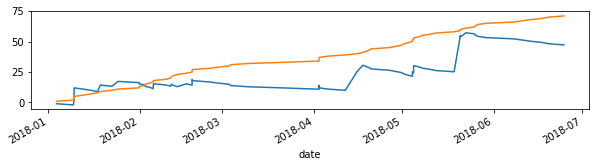

In [64]:
bb = bets[ ((bets['nb']==2) ) & (bets['target']=='pred_stacked_mlp_relu_1') & (bets['odds_ref']<8) & (bets['odds_ref']>3) & (bets['pred']<=1)]
#bb = bets[ ((bets['nb']==2) ) & (bets['target']!='fpred_knn_2_1') & (bets['odds_ref']<10) & (bets['odds_ref']>3) & (bets['pred']>0.1)]
#bb = bets[ (bets['country']!='dFRA') & (bets['sub_category']!='dNATIONALE_AUTOSTART') & (bets['nb']==1) & (bets['target']!='kpred_knn_1_1') & (bets['pred']>0.) & (bets['odds_ref']<10) & (bets['odds_ref']>1)  ].copy()
#bb = bets[ (bets['country']=='FRA') & (bets['sub_category']!='COURSE_A_CONDITIONS') & (bets['nb']==0) & (bets['odds_ref']>=bets['odds_1']) & (bets['odds_ref']<20) & (bets['target']!='psred_mlp_20_1') ].copy()
#bb = bets[ (bets['country']=='FRA') & (bets['sub_category']=='AUTOSTART') & (bets['nb']<=0) & (bets['odds_ref']>=0) & (bets['odds_ref']<20) ].copy()
#bb = bets[ (bets['country']=='FRA') & (bets['sub_category']!='COURSE_A_CONDITIONS') & (bets['nb']==0) & ( (bets['target']=='pred_knn_10_1') | (bets['target']=='pred_minus_ref_lasso_1') ) & (bets['odds_ref']>10) & (bets['odds_ref']<20) & (bets['pred']>20)].copy()        
#bb = bets[ (bets['country']=='FRA') & (bets['nb']==0) & (bets['odds_ref']>10) & (bets['odds_ref']<20) & (bets['pred']>0)].copy()
#bb = bb.groupby('id').filter(lambda r: r['num'].count() == 2)
#graph_bb( bets[(bets['target']=='pred_lasso_0.1_1') & (bets['nb']==0) & (bets['odds_ref']>5) & (bets['odds_ref']<20) & (bets['pred']>0.)], 'sub_category')
#bb['profit'] = bb['profit'] * 1/(1+bb['nb'])
#bb['bet'] = bb['bet'] * 1/(1+bb['nb'])

#bb['profit'] = bb['profit'] * np.round(bb['pred']*100)
#bb['bet'] = bb['bet'] * np.round(bb['pred']*100)

graph_bb(bb, 'sub_category')




In [62]:
bb


,id,date,num,pos,nb,odds_ref,odds_final,target,pred,pred_std,bet,profit,profit_placed,next_pred_1,next_pred_2,next_pred_3,declared_player_count,handicap_distance,handicap_distance_amax,handicap_distance_amin,handicap_distance_mean,handicap_distance_r,handicap_distance_std,handicap_weight,handicap_weight_amax,handicap_weight_amin,handicap_weight_mean,handicap_weight_r,handicap_weight_std,hist_1_pos,hist_2_pos,hist_3_pos,hist_4_pos,hist_5_pos,hist_6_pos,num,odds_0,odds_1,odds_2,odds_3,odds_4,odds_5,odds_6,odds_7,odds_8,odds_9,placed_2_count,placed_2_count_amax,placed_2_count_amin,placed_2_count_mean,placed_2_count_r,placed_2_count_std,placed_3_count,placed_3_count_amax,placed_3_count_amin,placed_3_count_mean,placed_3_count_r,placed_3_count_std,placed_earnings,placed_earnings_amax,placed_earnings_amin,placed_earnings_mean,placed_earnings_r,placed_earnings_std,prev_year_earnings,prev_year_earnings_amax,prev_year_earnings_amin,prev_year_earnings_mean,prev_year_earnings_r,prev_year_earnings_std,prize,race_count,race_count_amax,race_count_amin,race_count_mean,race_count_r,race_count_std,victory_count,victory_count_amax,victory_count_amin,victory_count_mean,victory_count_r,victory_count_std,victory_earnings,victory_earnings_amax,victory_earnings_amin,victory_earnings_mean,victory_earnings_r,victory_earnings_std,category,sub_category,country,bets,stash
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-03 20:55:00,11183,2018-01-03 20:55:00,9,4.0,2,7.8,7.7,pred_stacked_mlp_relu_1,-2.1830234,0.9708482,1,-1.0,-1.0,-2.2788447,-2.2815905,-2.3404829,9,2150,2150,2150,2150,100000.0,0.0,0.0,0.0,0.0,0.0,100000.0,0.0,3.0,3.0,0.0,4.0,4.0,0.0,9,1.8,7.0,7.8,8.1,9.0,18.5,18.8,42.2,100000.0,100000.0,0,0,0,0.0000000,100000.0000000,0.0000000,0,0,0,0.0000000,100000.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,100000.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,100000.0000000,0.0000000,4250,0,0,0,0.0000000,100000.0000000,0.0000000,0,0,0,0.0000000,100000.0000000,0.0000000,13.6806079,13.8761361,13.4615476,13.6841060,-0.0210820,0.1659246,ATTELE,AUTOSTART,ESP,2298,-921.8
2018-01-09 12:40:00,13746,2018-01-09 12:40:00,1,NaN,2,6.4,6.6,pred_stacked_mlp_relu_1,-1.5862472,0.3480876,1,-1.0,-1.0,-1.6138034,-1.7961144,-1.9579379,8,2100,2100,2100,2100,100000.0,0.0,0.0,0.0,0.0,0.0,100000.0,0.0,5.0,5.0,0.0,2.0,0.0,0.0,1,2.7,3.6,6.2,6.4,13.8,15.5,26.6,27.7,100000.0,100000.0,1,2,0,0.6250000,0.5040161,0.7440238,0,2,0,0.7500000,-0.8461141,0.8864053,13.9596118,13.9639314,0.0000000,11.4971596,0.5138675,4.7919978,13.9596118,14.0282005,0.0000000,11.8929434,0.4284763,4.8232967,34000,4,8,1,4.7500000,-0.3330398,2.2519833,0,1,0,0.2500000,-0.5400617,0.4629100,13.9596118,14.0282005,0.0000000,11.9351109,0.4183051,4.8397704,ATTELE,AUTOSTART,FRA,5458,-2365.2
2018-01-09 18:03:00,13771,2018-01-09 18:03:00,5,1.0,2,7.3,7.4,pred_stacked_mlp_relu_1,0.6686257,0.2111672,1,3.2,1.3,0.6212637,0.5734051,0.5564015,15,2300,2300,2300,2300,100000.0,0.0,0.0,0.0,0.0,0.0,100000.0,0.0,5.0,5.0,4.0,0.0,0.0,2.0,5,4.3,6.0,7.3,7.5,8.3,12.8,14.1,15.7,17.6,18.0,1,2,0,0.4666667,0.7175950,0.7432234,0,3,0,0.4000000,-0.4830459,0.8280787,12.8739046,12.8739046,0.0000000,10.7144033,0.6930959,3.1157323,13.5531076,13.5531076,0.0000000,11.0263642,0.7815719,3.2328993,6000,11,15,0,5.9333333,1.2931070,3.9182114,3,3,0,0.6000000,2.6366122,0.9102590,13.5531076,13.5531076,9.6158721,11.8787913,1.5296671,1.0945625,ATTELE,AUTOSTART,BEL,5829,-2663.1
2018-01-09 18:32:00,13772,2018-01-09 18:32:00,4,1.0,2,6.7,7.1,pred_stacked_mlp_relu_1,0.7416756,0.5286558,1,5.4,1.2,0.4911965,0.4357989,0.2960990,11,2300,2300,2300,2300,100000.0,0.0,0.0,0.0,0.0,0.0,100000.0,0.0,5.0,0.0,5.0,0.0,8.0,8.0,4,5.0,5.1,6.7,7.3,7.5,10.1,11.3,13.4,18.9,21.8,4,10,0,2.6363636,0.4994454,2.7303013,0,5,0,1.7272727,-0.9342505,1.8488326,14.4719943,14.4735491,12.7188993,13.8741027,1.0014824,0.5970066,11.0821579,13.4400910,0.0000000,11.1949936,-0.0297220,3.7963642,6000,28,52,11,31.2727273,-0.26

In [66]:
program.df['category'].value_counts()

ATTELE    8472
MONTE       10
Name: category, dtype: int64

In [68]:
mode = 'INTERNET'
mode.lower()

'internet'